In [ ]:
import pandas as pd
import numpy as np
import keras
import glob
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import roc_curve, auc

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K
from tensorflow.keras.applications.mobilenet import MobileNet

import os

Se va introduce calea fisierelor care contin fotografiile pentru antrenare si testare ale fiecarei clase

In [ ]:
# test and train file paths
classes = ['food', 'notfood'] #alphabetical order
train_path = '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/'
test_path = '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/test/'
food = glob.glob(train_path + classes[0]+'/*')
notfood = glob.glob(train_path + classes[1]+'/*')
train_classes = [food,notfood]
train_total = 0
for i in train_classes:
  train_total += len(i)

food_test = glob.glob(test_path + classes[0]+'/*')
notfood_test = glob.glob(test_path + classes[1]+'/*')
test_classes = [food_test,notfood_test]
test_total = 0
for i in test_classes:
  test_total += len(i)

# total train and test images for each category
print('Number of images per class:\nclass\t\ttrain\ttest')
for i in range(len(classes)):
  if len(classes[i])<=5: #extra \t spacing for short words to align every text column 
    print('{}:\t\t{}\t{}\n'.format(classes[i],len(train_classes[i]),len(test_classes[i])))
  else:
    print('{}:\t{}\t{}\n'.format(classes[i],len(train_classes[i]),len(test_classes[i])))
print('Total:\t\t{}\t{}'.format(train_total,test_total))

Number of images per class:
class		train	test
food:		1000	250

notfood:	1000	250

Total:		2000	500


Previzualizarea imaginilor inainte de procesarea specifica pentru antrenarea modelului MobileNet si analizarea setului de date.

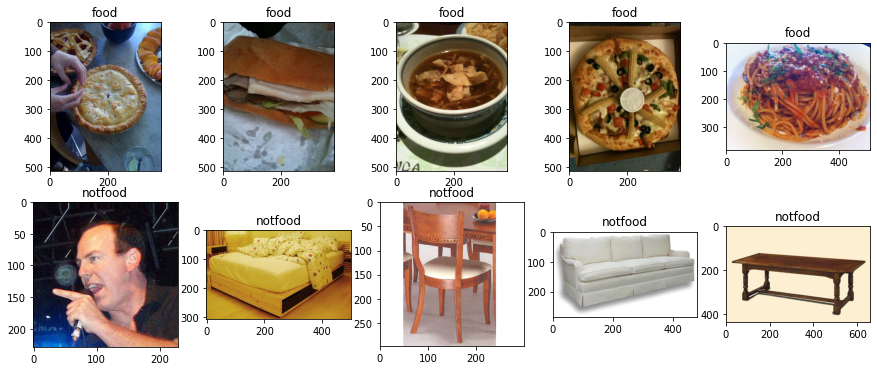

In [ ]:
# preview 5 images of each class
classes = ['food', 'notfood']
train_classes = [food,notfood]
nr = 5 #show 5 images from every class

classes_number = len(classes)
fig, axes = plt.subplots(classes_number,nr,figsize=(15,6))

for i in range(classes_number):
  for j in range(nr):
    axes[i, j].imshow(plt.imread(train_classes[i][j*200]))#show only every 200th image from class dataset
    axes[i, j].set_title(classes[i])

Se poate observa ca fotografiile sunt diferite din punct de vedere al calitatii lor. Astfel, unele imagini sunt suprinse in lumina nefavorabila, si au dimensiuni, fundaluri si zgomot de imagine cu intensitati diferite.

## **Data Augmentation**

Marirea datelor formate din imagini reprezinta o tehnica folosita in invatarea profunda pentru a extinde in mod artificial setul de date folosit pentru antrenarea modelului. Prin aceasta tehnica sunt create versiuni (copii) ale imaginilor originale, dar cu mici modificari, fiind afectate de diferiti factori.

Datorita acestui proces se obtine o crestere a performantei modelului si a abilitatii sale de a generaliza. Astfel, se evita memorarea imaginilor si sunt invatate tipare.

Acest proces creeaza noi imagini care ofera senzatia de captura din diferite unghiuri a unui obict 3D(tridimensional) - ofera senzatie de intelegere 3D a obiectului

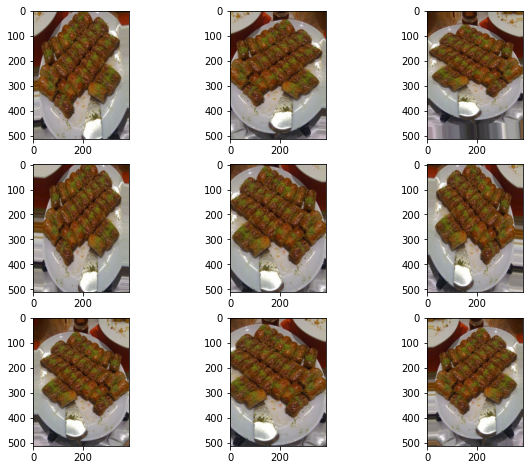

In [ ]:
# example of one image after image augmentation
# load the image
img = load_img(food[10])
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = np.expand_dims(img, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5, #randomly rotate images in the range(degrees, 0 to 180)
                 width_shift_range=0.05, #randomly shift images horizontally (percentage of total width)
                 height_shift_range=0.05, ##randomly shift images vertically (percentage of total height)
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True, #flip images horizontally but not vertically because food can't stay upside down on the plate or table.
                 vertical_flip=False)
# prepare iterator #just flow because it is not from directory, its just an image sample
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
fig, axes = plt.subplots(3,3,figsize=(10,8))
for i in range(3):
  for j in range(3):
    # define subplot
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    axes[i,j].imshow(image)
# show the figure
plt.show()

Marirea intregului set de date:

In [ ]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5, #randomly rotate images in the range(degrees, 0 to 180)
                 width_shift_range=0.05, #randomly shift images horizontally (percentage of total width)
                 height_shift_range=0.05, ##randomly shift images vertically (percentage of total height)
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True, #flip images horizontally but not vertically because food can't stay upside down on the plate or table and video is vertical so every object is gonna stay as first person view.
                 vertical_flip=False,
                 rescale=1/255) #normalize image, add zoom range of 0.2x and horizontal flip
train_generator = train_datagen.flow_from_directory( #images are loaded progressively in alphabetical order and assigned an integer for each class 
        train_path,
        target_size=(224,224),
        batch_size=16)
test_datagen = ImageDataGenerator(rescale=1/255) # just normalize for testing set
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        batch_size=16)

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


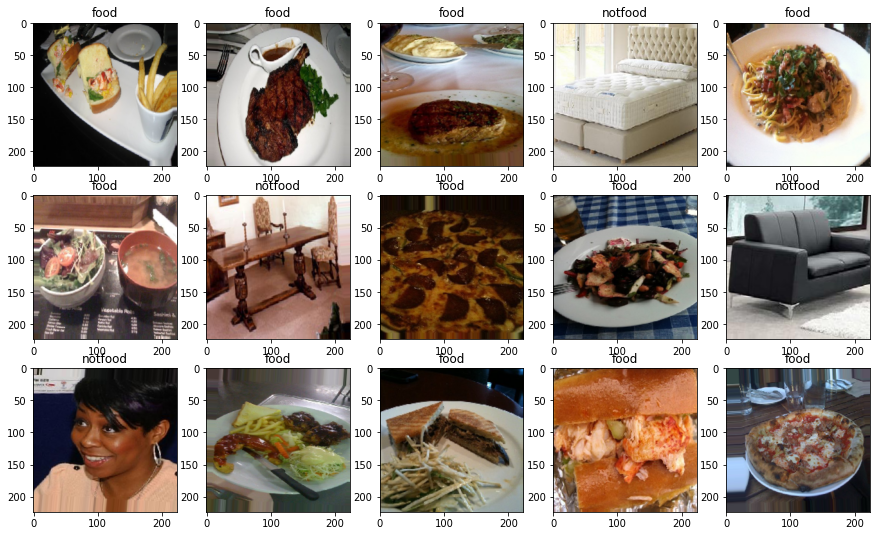

In [ ]:
# preview images from train generator
r = 3; c = 5
n=0
classtolabel = {'0':'food','1':'notfood'} #alphabetical order, each class assigned an integer because of flow_from_directory() function
for x in train_generator:
    fig, axes = plt.subplots(r,c,figsize=(15,9))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

## **Modelare**

Antrenarea modelului va fi facuta prin tehnica transfer learning. Astfel, setul de date si durata necesara pentru antrenare pot fi mai mici. Modelul de baza peste care se aplica noile cunostinte este modelul Keras MobileNet. Aacest model a fost antrenat pe setul de date Imagenet.

In [ ]:
nclass = len(train_generator.class_indices)
base_model = MobileNet(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = False
base_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________

Diluarea (Dropout) este o tehnică de regularizare pentru reducerea supraîncadrării(overfitting) în rețelele neuronale artificiale prin prevenirea memorizarii datelor de antrenament. In arhitectura modelului antrenat voi renunta la 20% din datele de antrenare.

Stratul de iesire are 2 neuroni deoarece sunt 2 clase folosite pentru clasificarea imaginilor. nclass reprezinta numarul de clase, deci numarul de neuroni din ultimul strat.(A fost folosit in functia Dense())

In [ ]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dropout(0.2),#dropout 20% of data to avoid memorization 
  Dense(nclass, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2())]) #softmax activation is for multi class problems and the addition of the probabilities of each class equals to 1.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 2,050
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
#callbacks
checkpointer = ModelCheckpoint(filepath='modelMobileNet2ClassesFoodVsNotfood.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])#categorical cross-entropy used for multi class problems

Antrenare pentru 100 epoci.

In [ ]:
batch_size = 16
history = model.fit(train_generator,steps_per_epoch=train_total/batch_size,
                              validation_data=test_generator,validation_steps=test_total/batch_size, 
                              epochs=100, callbacks=[checkpointer, reduceLR, earlystopping])

Epoch 1/100
125/125 [==============================] - 615s 5s/step - loss: 0.3363 - accuracy: 0.8575 - val_loss: 0.0548 - val_accuracy: 0.9980

Epoch 00001: val_loss improved from inf to 0.05477, saving model to modelMobileNet2ClassesFoodVsNotfood.hdf5
Epoch 2/100
125/125 [==============================] - 129s 1s/step - loss: 0.0615 - accuracy: 0.9951 - val_loss: 0.0452 - val_accuracy: 0.9980

Epoch 00002: val_loss improved from 0.05477 to 0.04524, saving model to modelMobileNet2ClassesFoodVsNotfood.hdf5
Epoch 3/100
125/125 [==============================] - 128s 1s/step - loss: 0.0487 - accuracy: 0.9951 - val_loss: 0.0396 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.04524 to 0.03962, saving model to modelMobileNet2ClassesFoodVsNotfood.hdf5
Epoch 4/100
125/125 [==============================] - 127s 1s/step - loss: 0.0397 - accuracy: 0.9977 - val_loss: 0.0344 - val_accuracy: 0.9980

Epoch 00004: val_loss improved from 0.03962 to 0.03444, saving model to modelMobileNe

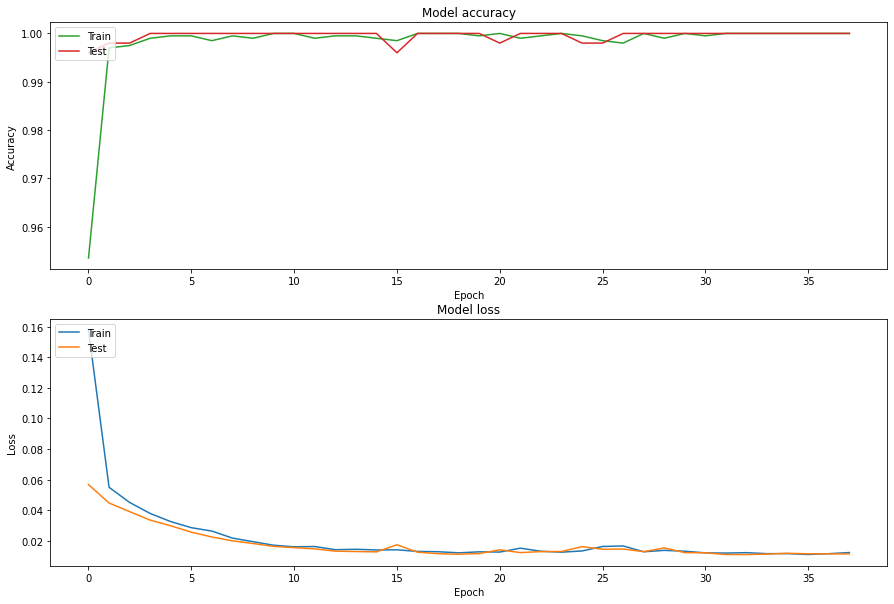

In [ ]:
def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['accuracy'],c='C2')
    ax[0].plot(history.history['val_accuracy'],c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'],c='C0')
    ax[1].plot(history.history['val_loss'],c='C1')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
plot_hist(history)

## **Evaluarea rezultatelor**

In [ ]:
# create another generator for all test images in a single batch
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        batch_size=test_total)

Found 500 images belonging to 2 classes.


**Predictii**

Incarcarea modelului salvat

In [ ]:
export_path_keras = "/content/drive/MyDrive/Colab Projects/model2classesFoodVsNotfood-MobileNet.h5"
model = load_model(export_path_keras)

Procentul de acuratete al modelului antrenat: 100%

In [ ]:
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 100.0%


Verificarea a 10 predictii la intamplare

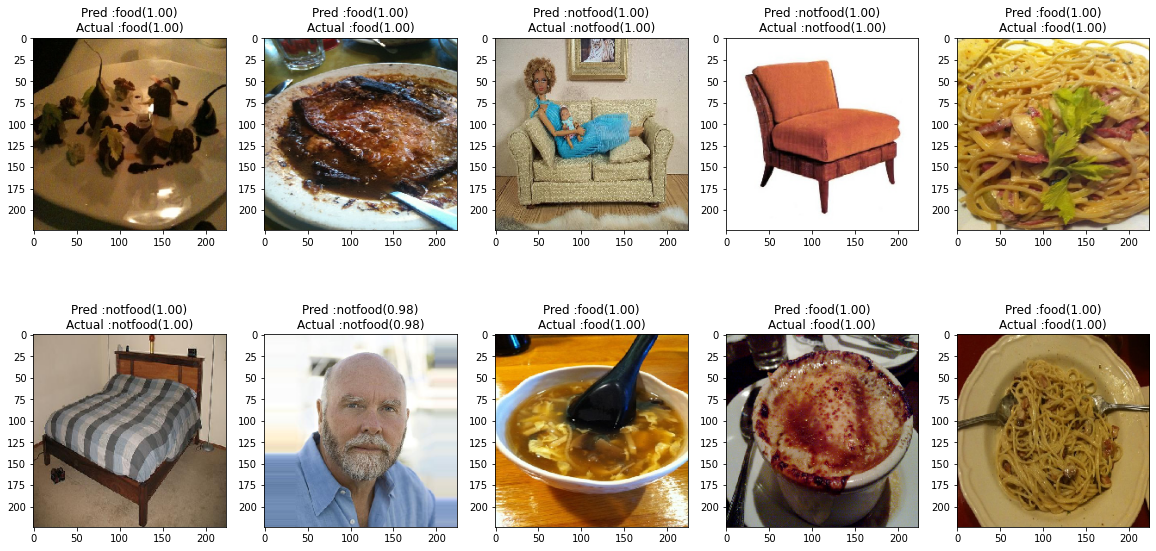

In [ ]:
f, ax=plt.subplots(2,5,figsize=(20,10))
for k in range(2):
  for l in range(5):
      j=np.random.randint(1,len(x_test))
      ax[k,l].imshow(x_test[j])
      ax[k,l].set_title("Pred :{}({:.2f})\nActual :{}({:.2f})".format
                            (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                            classtolabel[str(y_label[j])],y_pred_conf[j][(y_label[j])],fontweight="bold", size=20))

**Matricea confuziilor**

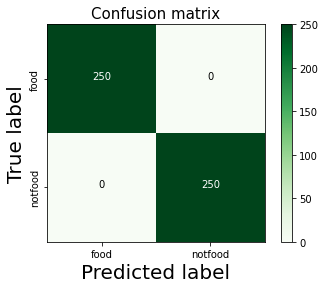

In [ ]:
def plot_confusion_matrix(cm):    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = ['food', 'notfood'] 
    plt.xticks([i for i in range(len(classes))], classes, fontsize=10)
    plt.yticks([i for i in range(len(classes))], classes, fontsize=10,rotation=90,verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=20)
    plt.ylabel('True label',fontsize=20)
    
plot_confusion_matrix(confusion_matrix(y_label,y_pred))

Din setul de testare nu exista predictii eronate, acuratetea este de 100%.

## **Salvarea modelului**

Voi salva modelul sub formatul de fisier HDF5 specific Keras. Fisierul HDF5 va avea extensia .h5

In [ ]:
export_path_keras = "/content/drive/MyDrive/Colab Projects/model2classesFoodVsNotfood-MobileNet.h5"
print(export_path_keras)

model.save(export_path_keras)

/content/drive/MyDrive/Colab Projects/model2classesFoodVsNotfood-MobileNet.h5


Incarcarea modelului salvat

In [ ]:
export_path_keras = "/content/drive/MyDrive/Colab Projects/model2classesFoodVsNotfood-MobileNet.h5"
reloaded = load_model(export_path_keras)

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 2,050
Non-trainable params: 3,228,864
_________________________________________________________________


## **Predictia unei singure imagini**

Imaginea va fi incarcata din Google Drive

array([[0.7507043 , 0.24929568]], dtype=float32)

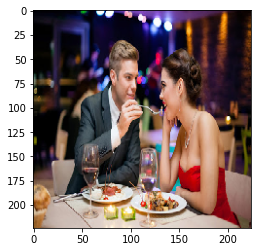

In [ ]:
img=load_img('/content/drive/MyDrive/Colab Projects/Test_images_from_google/unnamed.jpg',target_size=(224,224))
plt.imshow(img)
img = np.array(img).astype('float32')/255
img = np.expand_dims(img, axis=0)
reloaded.predict(img)

In [ ]:
classtolabel = {'0':'food','1':'notfood'}
result = reloaded.predict(img)
maximum = np.max(result)
y_pred = np.argmax(result,axis=1)
print(classtolabel[str(y_pred[0])])

food
